This is the 2D equivalent of the 1D example. It is meant to show that ROMC method scales well to higher dimensions.

In [5]:
import timeit

import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as integrate
import scipy.ndimage as ndimage
import scipy.stats as ss
from mpl_toolkits import mplot3d

import elfi

np.random.seed(21)

In [6]:
class Prior:
    def rvs(self, size=None, random_state=None):
        # size from (BS,) -> (BS,1)
        if size is not None:
            size = np.concatenate((size, [1]))
        return ss.uniform(loc=-2.5, scale=5).rvs(size=size, random_state=random_state)

    def pdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).pdf(theta)

    def logpdf(self, theta):
        return ss.uniform(loc=-2.5, scale=5).logpdf(theta)

In [7]:
class Likelihood:
    def rvs(self, th1, th2, seed=None):
        assert isinstance(th1, np.ndarray)
        assert isinstance(th2, np.ndarray)
        assert th1.ndim == 2
        assert th2.ndim == 2
        assert np.allclose(th1.shape, th2.shape)

        x = []
        for i in range(th1.shape[0]):
            cur_th = np.concatenate((th1[i], th2[i]))
            x.append(ss.multivariate_normal(mean=cur_th, cov=1).rvs(random_state=seed))
        return np.array(x)

    def pdf(self, x, th1, th2):
        assert isinstance(th1, float)
        assert isinstance(th2, float)
        assert isinstance(x, np.ndarray)

        th = np.stack((th1, th2))
        rv = ss.multivariate_normal(mean=th, cov=1)
        nof_points = x.shape[0]
        prod = 1
        for i in range(nof_points):
            prod *= rv.pdf(x[i])
        return prod

## Numerical ground-truth computation

In [44]:
def create_factor(x):
    lik = Likelihood()
    pr = Prior()

    def tmp_func(th1, th2):
        return lik.pdf(x, th1, th2) * pr.pdf(th1) * pr.pdf(th2)
    return tmp_func


def approximate_Z(func):
    return integrate.dblquad(func, -2.5, 2.5, lambda x: -2.5, lambda x: 2.5)[0]


def create_gt_posterior(factor, Z):
    def tmp_func(th1, th2):
        return factor(th1, th2) / Z
    return tmp_func

def plot_gt_posterior(posterior, nof_points):
    plt.figure()
    x = np.linspace(-4, 4, nof_points)
    y = np.linspace(-4, 4, nof_points)

    x, y = np.meshgrid(x, y)

    tmp = []
    for i in range(x.shape[0]):
        tmp.append([])
        for j in range(x.shape[1]):
            tmp[i].append(posterior(x[i, j], y[i, j]))
    z = np.array(tmp)
    plt.contourf(x, y, z, 40)
    plt.title('Ground-Truth Posterior PDF')
    plt.colorbar()
    plt.xlabel("th_1")
    plt.ylabel("th_2")
    plt.show(block=False)

def create_gt_marginal_1(factor, Z):
    def tmp_func(th1):
        def integrand(th2):
            return factor(th1, th2)
        return integrate.quad(integrand, -2.5, 2.5)[0] / Z
    return tmp_func


def create_gt_marginal_2(factor, Z):
    def tmp_func(th2):
        def integrand(th1):
            return factor(th1, th2)
        return integrate.quad(integrand, -2.5, 2.5)[0] / Z
    return tmp_func

def plot_gt_marginals(marg_1, marg_2, nof_points):
    plt.figure()
    x = np.linspace(-3, 3, nof_points)
    y = [marg_1(tmp_x) for tmp_x in x]
    plt.plot(x, y, "r--", label=r"$p(\theta_1|y_0)$")
    y = [marg_2(tmp_x) for tmp_x in x]
    plt.plot(x, y, "b--", label=r"$p(\theta_2|y_0)$")
    plt.title("Ground-truth marginals")
    plt.xlabel(r"$\theta_i$")
    plt.ylabel(r"$p(\theta_i|\mathbf{y_0})$")
    plt.legend()
    plt.show(block=False)


def compute_gt_mean(gt_marginal):
    def h(x):
        return gt_marginal(x)*x
    return integrate.quad(h, -2.5, 2.5)


def compute_gt_std(gt_marginal, m):
    def h(x):
        return gt_marginal(x)*((x-m)**2)
    return np.sqrt(integrate.quad(h, -2.5, 2.5))

def plot_marginal(samples, weights, mean, std, marg, title, xlabel, ylabel, bins,
                  range, ylim):
    plt.figure()
    plt.title(title)
    plt.hist(x=samples,
             weights=weights,
             bins=bins, density=True, range=range)
    # plt.axvline(mean, 0, 1,
    #             color="r", linestyle="--", label=r"$\mu = %.3f$" % (mean))
    # plt.axhline(.2,
    #             (mean-std-range[0])/(range[1] - range[0]),
    #             (mean+std-range[0])/(range[1] - range[0]),
    #             color="k",
    #             linestyle="--", label=r"$\sigma = %.3f$" % (std))
    x = np.linspace(-3, 3, 40)
    y = [marg(tmp_x) for tmp_x in x]
    plt.plot(x, y, "r--")
    plt.plot
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim)
    plt.show(block=False)


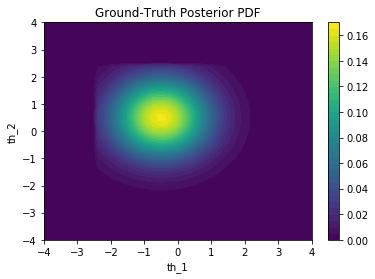

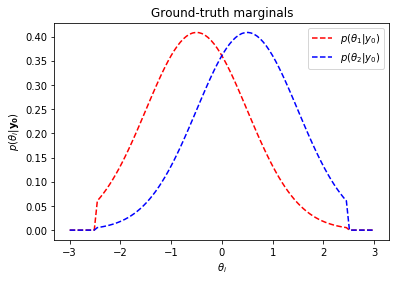

In [11]:
data = np.array([[-.5,.5]])
dim = data.shape[-1]
factor = create_factor(data)
Z = approximate_Z(factor)
gt_posterior = create_gt_posterior(factor, Z)

gt_marg_1 = create_gt_marginal_1(factor, Z)
gt_marg_2 = create_gt_marginal_2(factor, Z)
gt_mean_th1 = compute_gt_mean(gt_marg_1)[0]
gt_std_th1 = compute_gt_std(gt_marg_1, gt_mean_th1)[0]
gt_mean_th2 = compute_gt_mean(gt_marg_2)[0]
gt_std_th2 = compute_gt_std(gt_marg_2, gt_mean_th2)[0]
plot_gt_posterior(gt_posterior, nof_points=50)
plot_gt_marginals(gt_marg_1, gt_marg_2, nof_points=100)

## ELFI PART

In [12]:
def simulate_data(th1, th2, batch_size=10000, random_state=None):
    likelihood = Likelihood()
    return likelihood.rvs(th1, th2, seed=random_state)


def summarize(x):
    if x.ndim == 1:
        x = np.expand_dims(x, -1)
    return np.prod(x, axis=-1)

In [13]:
elfi.new_model("2D_example")
elfi_th1 = elfi.Prior(Prior(), name="th1")
elfi_th2 = elfi.Prior(Prior(), name="th2")
elfi_simulator = elfi.Simulator(simulate_data, elfi_th1, elfi_th2, observed=data, name="simulator")
dist = elfi.Distance('euclidean', elfi_simulator, name="dist")
summary = elfi.Summary(summarize, dist, name="summary")

In [14]:
bounds = [(-2.5, 2.5), (-2.5,2.5)]
romc = elfi.ROMC(summary, bounds)

# Training part, with gradient-based optimisation

In [15]:
n1 = 2000
seed = 21
romc.solve_problems(n1=n1, seed=seed)

### Solving problems using a gradient-based method ###
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 25.744 sec
Time: 25.744 sec


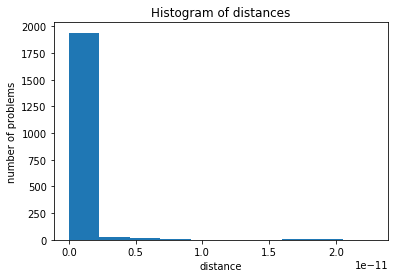

In [17]:
romc.distance_hist()

In [18]:
eps_filter = .4
romc.estimate_regions(eps_filter=eps_filter, fit_models=True)

Total solutions: 2000, Accepted solutions after filtering: 2000
### Estimating regions ###

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 124.829 sec 

### Fitting local models ###

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 50.271 sec 



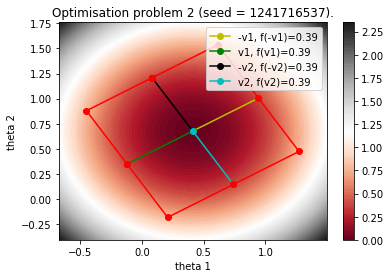

In [19]:
romc.visualize_region(2)

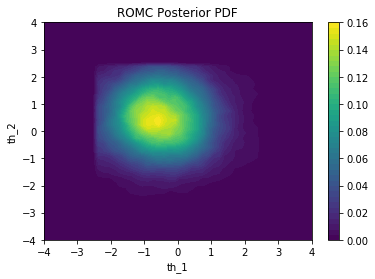

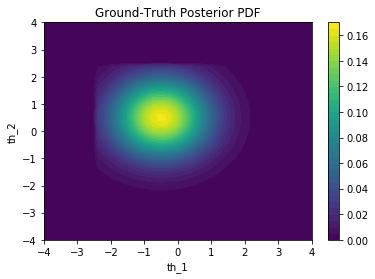

In [23]:
def plot_romc_posterior(posterior, nof_points):
    plt.figure()
    th1 = np.linspace(-4, 4, nof_points)
    th2 = np.linspace(-4, 4, nof_points)
    X, Y = np.meshgrid(th1, th2)

    x_flat = X.flatten()
    y_flat = Y.flatten()
    th = np.stack((x_flat, y_flat), -1)
    z_flat = posterior(th)
    Z = z_flat.reshape(nof_points, nof_points)
    
    plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.title('ROMC Posterior PDF')
    plt.xlabel("th_1")
    plt.ylabel("th_2")
    plt.colorbar()
    plt.show(block=False)
    
plot_romc_posterior(romc.eval_posterior, nof_points=50)
plot_gt_posterior(gt_posterior, nof_points=50)

In [24]:
n2 = 50
tmp = romc.sample(n2=n2)

### Getting Samples from the posterior ###

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Time: 242.300 sec 



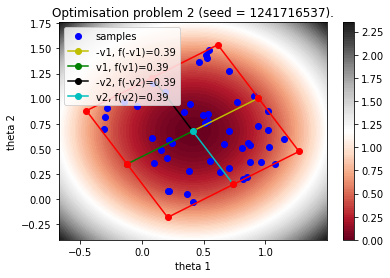

In [25]:
# As before but now it plots the samples as well
romc.visualize_region(2)

# Evaluation Part

In [30]:
# compute expectation
print("### theta 1: ###")
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.result.sample_means_array[0], gt_mean_th1))
print("Expected variance: %.3f, ground-truth: %.3f" % (np.sqrt(romc.result.samples_cov()[0][0]), gt_std_th1))

print("### theta 2: ###")
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.result.sample_means_array[1], gt_mean_th2))
print("Expected variance: %.3f, ground-truth: %.3f" % (np.sqrt(romc.result.samples_cov()[1][1]), gt_std_th2))

### theta 1: ###
Expected mean    : -0.467, ground-truth: -0.449
Covariance Matrix: 
[[ 0.94374778 -0.03116665]
 [-0.03116665  0.94595528]]
Expected variance: 0.971, ground-truth: 0.934
### theta 2: ###
Expected mean    : 0.425, ground-truth: 0.449
Covariance Matrix: 
[[ 0.94374778 -0.03116665]
 [-0.03116665  0.94595528]]
Expected variance: 0.973, ground-truth: 0.934


In [31]:
def wrapper(x):
    res = []
    for i in range(x.shape[0]):
        res.append(gt_posterior(x[i][0], x[i][1]))
    return np.array(res)

print("Divergence from ground-truth, using Jensen-Shannon distance: %.3f" % romc.compute_divergence(wrapper, step=1, distance="Jensen-Shannon"))

Divergence from ground-truth, using Jensen-Shannon distance: 0.059


In [32]:
# compute ESS
print("Nof Samples: %d, ESS: %.3f" % (len(romc.result.weights), romc.compute_ess()))

Nof Samples: 100000, ESS: 74503.000


Covariance Matrix: 
[[ 0.94374778 -0.03116665]
 [-0.03116665  0.94595528]]


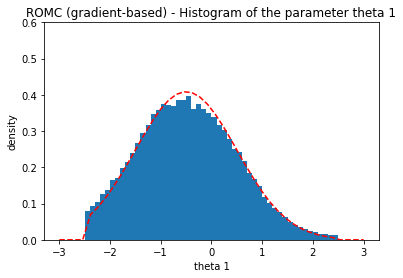

Covariance Matrix: 
[[ 0.94374778 -0.03116665]
 [-0.03116665  0.94595528]]


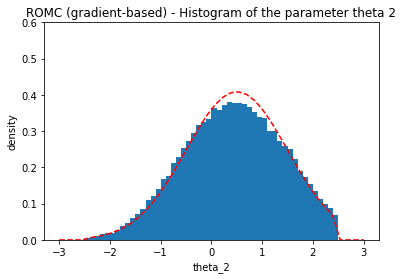

In [45]:
name = "t1"
plot_marginal(romc.result.samples_array[:,0], romc.result.weights,
              romc.result.sample_means_array[0],
              np.sqrt(romc.result.samples_cov()[0, 0]),
              gt_marg_1,
              "ROMC (gradient-based) - Histogram of the parameter theta 1",
              "theta 1",
              "density",
              50,
              bounds[0], (0, .6))

name = "t2"
plot_marginal(romc.result.samples_array[:,1], romc.result.weights,
              romc.result.sample_means_array[1],
              np.sqrt(romc.result.samples_cov()[1, 1]),
              gt_marg_2,
              "ROMC (gradient-based) - Histogram of the parameter theta 2",
              "theta_2",
              "density",
              50,
              bounds[1], (0, .6))


# romc.result.plot_marginals(weights=romc.result.weights, bins=100, density=True)
# plt.show()

# Training part, with Bayesian optimisation

We repeat the same procedure as before, using the Bayesian optimisation scheme. We will use less optimisation problems (n1=100), because the solving them is more time consuming using Bayesian Optimisation.

In [48]:
n1 = 100
seed = 21
romc.solve_problems(n1=n1, seed=seed, use_bo=True)

### Solving problems using Bayesian optimisation ###


KeyboardInterrupt: 

In [ ]:
romc.distance_hist()

In [ ]:
eps_filter = .4
romc.estimate_regions(eps_filter=eps_filter, fit_models=True)

In [ ]:
romc.visualize_region(2)

In [ ]:
def plot_romc_posterior(posterior, nof_points):
    plt.figure()
    th1 = np.linspace(-4, 4, nof_points)
    th2 = np.linspace(-4, 4, nof_points)
    X, Y = np.meshgrid(th1, th2)

    x_flat = X.flatten()
    y_flat = Y.flatten()
    th = np.stack((x_flat, y_flat), -1)
    z_flat = posterior(th)
    Z = z_flat.reshape(nof_points, nof_points)
    
    plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.title('ROMC Posterior PDF')
    plt.xlabel("th_1")
    plt.ylabel("th_2")
    plt.colorbar()
    plt.show(block=False)
    
plot_romc_posterior(romc.eval_posterior, nof_points=50)
plot_gt_posterior(gt_posterior, nof_points=50)

In [ ]:
n2 = 50
tmp = romc.sample(n2=n2)

In [ ]:
# As before but now it plots the samples as well
romc.visualize_region(2)

# Evaluation Part

In [ ]:
# compute expectation
print("### theta 1: ###")
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.result.sample_means_array[0], gt_mean_th1))
print("Expected variance: %.3f, ground-truth: %.3f" % (np.sqrt(romc.result.samples_cov()[0][0]), gt_std_th1))

print("### theta 2: ###")
print("Expected mean    : %.3f, ground-truth: %.3f" % (romc.result.sample_means_array[1], gt_mean_th2))
print("Expected variance: %.3f, ground-truth: %.3f" % (np.sqrt(romc.result.samples_cov()[1][1]), gt_std_th2))

In [ ]:
def wrapper(x):
    res = []
    for i in range(x.shape[0]):
        res.append(gt_posterior(x[i][0], x[i][1]))
    return np.array(res)

print("Divergence from ground-truth, using Jensen-Shannon distance: %.3f" % romc.compute_divergence(wrapper, step=1, distance="Jensen-Shannon"))

In [ ]:
# compute ESS
print("Nof Samples: %d, ESS: %.3f" % (len(romc.result.weights), romc.compute_ess()))

In [ ]:
name = "t1"
plot_marginal(romc.result.samples_array[:,0], romc.result.weights,
              romc.result.sample_means_array[0],
              np.sqrt(romc.result.samples_cov()[0, 0]),
              gt_marg_1,
              "ROMC (gradient-based) - Histogram of the parameter theta 1",
              "theta 1",
              "density",
              50,
              bounds[0], (0, .6))

name = "t2"
plot_marginal(romc.result.samples_array[:,1], romc.result.weights,
              romc.result.sample_means_array[1],
              np.sqrt(romc.result.samples_cov()[1, 1]),
              gt_marg_2,
              "ROMC (gradient-based) - Histogram of the parameter theta 2",
              "theta_2",
              "density",
              50,
              bounds[1], (0, .6))


# romc.result.plot_marginals(weights=romc.result.weights, bins=100, density=True)
# plt.show()